In [1]:
# import modules in the parent directory
import sys
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# turn off DeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
sys.path.append('..')
obo_path = '../hp.obo'

In [2]:
# load all synonyms generated by GPT-4o-mini
synonym_folder = '/Users/cl3720/Desktop/hpo-parser-fine-tuned-gemini/hpo_synonyms/gpt-4o-mini-2024-07-18'
expanded_hpo_name_dict = {}
if os.path.exists(synonym_folder):
# load the synonyms from the folder
# each file in the folder is a json file with the following format {"HP:XXXX": ["synonym1", "synonym2", "synonym3"]}
    for file in os.listdir(synonym_folder):
        with open(os.path.join(synonym_folder, file), "r") as f:
            expanded_hpo_name_dict.update(json.load(f))
len(expanded_hpo_name_dict)
print(f"There are {len(expanded_hpo_name_dict)} HPO terms with synonyms")
# load the HPO ontology
from HpoFactory import HpoFactory
hpoF = HpoFactory(obo_path)
hpo_tree = hpoF.build_hpo_tree()
hpo_ancestors = hpoF.get_hpo_ancestors(hpo_tree)
hpo_levels = hpoF.get_hpo_levels(hpo_tree)
hpo_ancestors_df = pd.DataFrame(hpo_ancestors.items(), columns=['hpo_id', 'ancestor'])
# add hp_id to the ancestor list in the ancestor column
hpo_ancestors_df['ancestor'] = hpo_ancestors_df.apply(lambda x: [x.hpo_id] + x.ancestor, axis=1)
hpo_ancestors_df.rename(columns={'hpo_id': 'hit_hpo_id'}, inplace=True)

There are 18330 HPO terms with synonyms


### Performance in Top 1 exactly matched results

In [13]:
result_json = './rag_evaluation_query_results_top1_default.json'    
# load the query results from the json file
with open(result_json, 'r') as f:
    query_results = json.load(f)

# # top 5 also contains top 1 results
result_json = './rag_evaluation_query_results_top5_default.json'
# load the query results from the json file
with open(result_json, 'r') as f:
    query_results = json.load(f)
    # convert to top 1 results
    query_results = {k: [vi['parsed_results'][0]['hpo_id'] for vi in v] for k, v in query_results.items()}
    # for some reason, the query results are not the same.

In [14]:
# merge two dictionary by keys
# convert expanded_hpo_name_dict into pandas dataframe
expanded_hpo_name_df = pd.DataFrame(expanded_hpo_name_dict.items(), columns=['query_hpo_id', 'synonyms'])
# convert query_results into pandas dataframe
query_results_df = pd.DataFrame(query_results.items(), columns=['query_hpo_id', 'hit_hpo_id'])
# merge the two dataframes
merged_df = pd.merge(expanded_hpo_name_df, query_results_df, on='query_hpo_id')
# expand the hit_hpo_ids into multiple rows
merged_df = merged_df.explode(['synonyms','hit_hpo_id'])
# overall accuracy query_hpo_id == hit_hpo_ids
overall_accuracy = (merged_df.query_hpo_id == merged_df.hit_hpo_id).mean()
# round 2 decimal places
print(f"Overall accuracy: {overall_accuracy:.2f}")
# by query_hpo_id at least one hit_hpo_ids == query_hpo_id
for at_leat_i_hit in range(1, 6):
    at_least_x_hit_accuracy = merged_df.groupby('query_hpo_id').apply(lambda x: (x.query_hpo_id == x.hit_hpo_id).value_counts().get(True, 0) >= at_leat_i_hit).mean()
    print(f"At least {at_leat_i_hit} hit accuracy: {at_least_x_hit_accuracy:1f}")

Overall accuracy: 0.42
At least 1 hit accuracy: 0.735843
At least 2 hit accuracy: 0.544517
At least 3 hit accuracy: 0.390344
At least 4 hit accuracy: 0.269285
At least 5 hit accuracy: 0.160938


### Performance in Top 1 desendants matched results

In [10]:
# accuracy counted by ancestors
merged_ancestor_df = hpo_ancestors_df.merge(merged_df, how='right')
# generate a column to indicate whether the hit_hpo_ids is in the ancestor list
merged_ancestor_df['query_is_ancestor'] = merged_ancestor_df.apply(
    lambda x: isinstance(x['ancestor'], (list, set)) and x['query_hpo_id'] in x['ancestor'],
    axis=1
)# To avoid TypeError: argument of type 'float' is not iterable
# accuracy by ancestors
ancestor_accuracy = merged_ancestor_df.query_is_ancestor.mean()
print(f"Accuracy by ancestors: {ancestor_accuracy:2f}")
# by query_hpo_id at least one hit_hpo_ids == ancestor
for at_leat_i_hit in range(1, 6):
    at_least_x_hit_accuracy = merged_ancestor_df.groupby('query_hpo_id').apply(lambda x: x.query_is_ancestor.value_counts().get(True, 0) >= at_leat_i_hit).mean()
    print(f"At least {at_leat_i_hit} hit accuracy by ancestors: {at_least_x_hit_accuracy:2f}")

Accuracy by ancestors: 0.472504
At least 1 hit accuracy by ancestors: 0.788707
At least 2 hit accuracy by ancestors: 0.605456
At least 3 hit accuracy by ancestors: 0.451064
At least 4 hit accuracy by ancestors: 0.320076
At least 5 hit accuracy by ancestors: 0.197218


### Performance in Top 5 exactly matched results

In [11]:
# top 5 match
result_json = './rag_evaluation_query_results_top5_default.json'
# load the query results from the json file
with open(result_json, 'r') as f:
    query_results = json.load(f)

In [12]:
# merge two dictionary by keys
# convert expanded_hpo_name_dict into pandas dataframe
expanded_hpo_name_df = pd.DataFrame(expanded_hpo_name_dict.items(), columns=['query_hpo_id', 'synonyms'])
expanded_hpo_name_df = expanded_hpo_name_df.explode('synonyms')
expanded_hpo_name_df.rename(columns={'synonyms': 'query_synonym'}, inplace=True)
# convert query_results into pandas dataframe
# Flatten the dictionary
rows = []
for key, value in query_results.items():
    for entry in value:
        synonym = entry.get('synonym', '')
        for result in entry.get('parsed_results', []):
            rows.append({
                'query_hpo_id': key,
                'query_synonym': synonym,
                'hit_hpo_id': result['hpo_id'],
                'hit_hpo_name': result['hpo_name'],
                'top_k': result['top_k'],
                'distance': result['distance']
            })

# Create a pandas DataFrame
query_results_df = pd.DataFrame(rows)
# query_results_df = pd.DataFrame(query_results.items(), columns=['query_hpo_id', 'hit_hpo_objects'])
# merge the two dataframes
merged_df = pd.merge(expanded_hpo_name_df, query_results_df, on=['query_hpo_id','query_synonym'])
# expand the hit_hpo_ids into multiple rows
total_pairs = merged_df.groupby(['query_hpo_id', 'query_synonym']).ngroups
# Load into pandas DataFrame
# Filter the DataFrame based on the conditions
for k in range(5):
    filtered_df = merged_df[(merged_df['top_k'] <= k) & (merged_df['query_hpo_id'] == merged_df['hit_hpo_id'])]
    # Count the unique "query_hpo_id, query_synonym" pairs
    count = filtered_df.groupby(['query_hpo_id', 'query_synonym']).ngroups
    # Calculate the percentage
    percentage = (count / total_pairs) * 100
    print(f"Top {k+1} accuracy: {percentage:.2f}%")

Top 1 accuracy: 42.02%
Top 2 accuracy: 53.30%
Top 3 accuracy: 59.43%
Top 4 accuracy: 63.31%
Top 5 accuracy: 66.16%


### Performance in Top 5 descendants matched results

In [13]:
# accuracy counted by ancestors
merged_ancestor_df = hpo_ancestors_df.merge(merged_df, how='right')
# generate a column to indicate whether the hit_hpo_ids is in the ancestor list
merged_ancestor_df['query_is_ancestor'] = merged_ancestor_df.apply(
    lambda x: isinstance(x['ancestor'], (list, set)) and x['query_hpo_id'] in x['ancestor'],
    axis=1
)# expand the hit_hpo_ids into multiple rows
total_pairs = merged_ancestor_df.groupby(['query_hpo_id', 'query_synonym']).ngroups
print(f"Total pairs: {total_pairs}")
# Load into pandas DataFrame
# Filter the DataFrame based on the conditions
for k in range(5):
    filtered_df = merged_ancestor_df[(merged_ancestor_df['top_k'] <= k) & (merged_ancestor_df['query_is_ancestor'] == True)]
    # Count the unique "query_hpo_id, query_synonym" pairs
    count = filtered_df.groupby(['query_hpo_id', 'query_synonym']).ngroups
    # Calculate the percentage
    percentage = (count / total_pairs) * 100
    print(f"Top {k+1} accuracy: {percentage:.2f}%")

Total pairs: 91649
Top 1 accuracy: 47.25%
Top 2 accuracy: 58.23%
Top 3 accuracy: 63.94%
Top 4 accuracy: 67.52%
Top 5 accuracy: 70.14%


/var/folders/jt/xqkngjbx2vj5dhrgmccfc01m0000gp/T/ipykernel_68730/4041769767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_plot_df['query_is_ancestor'] = for_plot_df['query_is_ancestor'].astype(str)


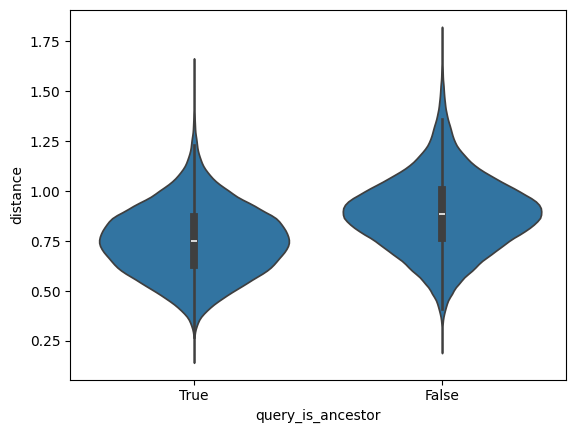

count    90377.000000
mean         0.752533
std          0.172679
min          0.176076
25%          0.628408
50%          0.749992
75%          0.869670
max          1.629961
Name: distance, dtype: float64
count    367883.000000
mean          0.889187
std           0.189695
min           0.218588
25%           0.765594
50%           0.886850
75%           1.003775
max           1.794064
Name: distance, dtype: float64
TtestResult(statistic=-197.40516808795678, pvalue=0.0, df=458258.0)
MannwhitneyuResult(statistic=9837255211.0, pvalue=0.0)


In [19]:
# plot distantce distribution by query_is_ancestor
for_plot_df = merged_ancestor_df[['query_is_ancestor','distance']]
for_plot_df['query_is_ancestor'] = for_plot_df['query_is_ancestor'].astype(str)
sns.violinplot(x='query_is_ancestor', y='distance', data=for_plot_df)
plt.show()
# do t test to show the differences
from scipy.stats import ttest_ind
query_is_ancestor = for_plot_df.query('query_is_ancestor == "True"')['distance']
query_is_not_ancestor = for_plot_df.query('query_is_ancestor == "False"')['distance']
# print summary statistics
print(query_is_ancestor.describe())
print(query_is_not_ancestor.describe())
t_test = ttest_ind(query_is_ancestor, query_is_not_ancestor)
print(t_test)
# do mannwhitneyu test to show the differences
from scipy.stats import mannwhitneyu
mannwhitneyu_test = mannwhitneyu(query_is_ancestor, query_is_not_ancestor)
print(mannwhitneyu_test)